In [3]:
import utils
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LRScheduler
	
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sde = utils.VPSDE(T_max=1, beta_min=0.01, beta_max=10.0)
image_size = 28
classes_by_index  = np.arange(0,10).astype('str')

transform = transforms.Compose([transforms.Resize(image_size),\
                                transforms.ToTensor(),\
                                transforms.Normalize([0.5],[0.5])]) #Normalize to -1,1
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                    download=True, transform=transform)

batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [4]:
class MNISTClassifier(nn.Module):
    """Code from: https://nextjournal.com/gkoehler/pytorch-mnist"""
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, t):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(x + t[:, None])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

def train_diffused_classifier(model, sde: utils.ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, scheduler: LRScheduler = None):
    
    model.train()
    model = model.to(DEVICE)
    running_loss_list = []
    lr_list = []
    
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, (x_inp,target) in enumerate(dataloader):
            
            #Zero gradients:
            optimizer.zero_grad()
            
            #Run forward samples:
            X_t,noise,score,time = sde.run_forward_random_time(x_inp)

            #Send to device:
            X_t = X_t.to(DEVICE)
            noise = noise.to(DEVICE)
            time = time.to(DEVICE)
            
            #Predict score:
            model_pred = model(X_t,time)

            #ONLY THIS LINE CHANGED TO BEFORE: we train the model to minimize the negative log-likelihood:
            loss = F.nll_loss(model_pred, target.to(DEVICE))

            #Optimize:
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()
                
            # print statistics
            running_loss += loss.detach().item()
            
            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                if scheduler is not None:
                    print(f"Loss: {avg_loss:.4f} | {scheduler.get_lr()}")
                    lr_list.append(scheduler.get_lr())
                else:
                    print(f"Loss: {avg_loss:.4f}")

                
    return model,running_loss_list

LEARNING_RATE = 1e-3 #2e-5
WEIGHT_DECAY = 0.0
N_EPOCHS = 500
TRAIN_SCORE = False
RETRAIN = False
classifier = MNISTClassifier()

if RETRAIN:
    optimizer = torch.optim.AdamW(classifier.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,LEARNING_RATE,total_steps=N_EPOCHS*len(trainloader),pct_start=0.25,anneal_strategy='cos')
    classifier,running_loss_list = train_diffused_classifier(classifier, sde, trainloader, optimizer=optimizer, scheduler=scheduler, device=DEVICE, n_epochs=N_EPOCHS, print_every=100)
    torch.save(classifier.state_dict(),"mnist_diffusion_classifier.ckpt")
    
else:
    classifier_state_dict = torch.load("mnist_diffusion_classifier.ckpt")
    classifier.load_state_dict(classifier_state_dict)
    classifier = classifier.to(DEVICE)



C:\Users\14153\AppData\Local\Temp\ipykernel_26576\556329269.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier_state_dict = torch.load("mnist_diffusion_classifi

C:\Users\14153\AppData\Local\Temp\ipykernel_26576\556329269.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


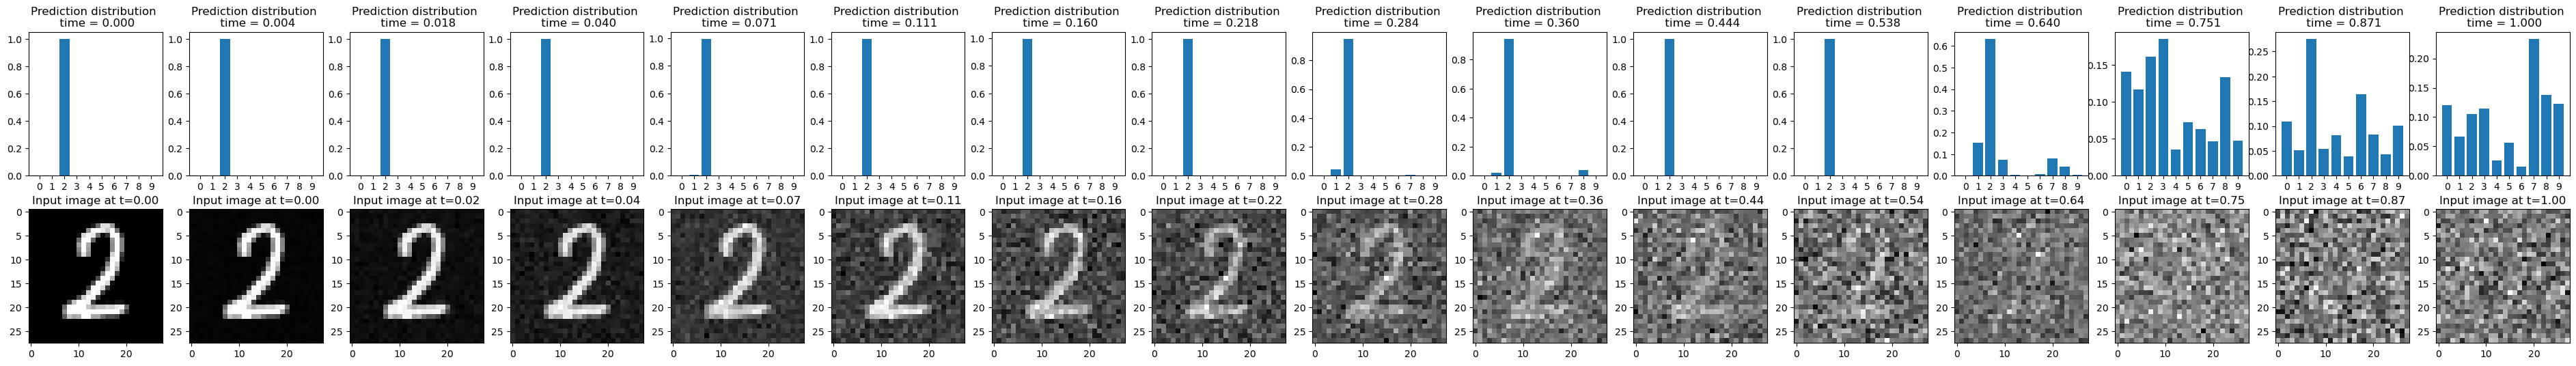

In [5]:
n_grid_points = 16
time_vec = torch.linspace(0,1,n_grid_points)**2
X_0, Y = trainset.__getitem__(23410)
X_0 = torch.stack([X_0.unsqueeze(0).squeeze()]*n_grid_points)
X_t, noise, score = sde.run_forward(X_0,time_vec)
X_t = X_t.unsqueeze(1)

results = np.exp(classifier(X_t.to(DEVICE),time_vec.to(DEVICE)).cpu().detach().numpy())
fig, axs = plt.subplots(2, len(results),figsize=(3*len(results),6))
for idx in range(len(results)):
    axs[0,idx].set_title(f"Prediction distribution \n time = {time_vec[idx]:.3f}")
    axs[0, idx].bar(x=classes_by_index, height=results[idx])
    axs[1, idx].set_title(f"Input image at t={time_vec[idx]:.2f}")
    axs[1, idx].imshow(X_t[idx].squeeze(), cmap='grey')

torch.Size([16, 1, 28, 28])


C:\Users\14153\AppData\Local\Temp\ipykernel_26576\556329269.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


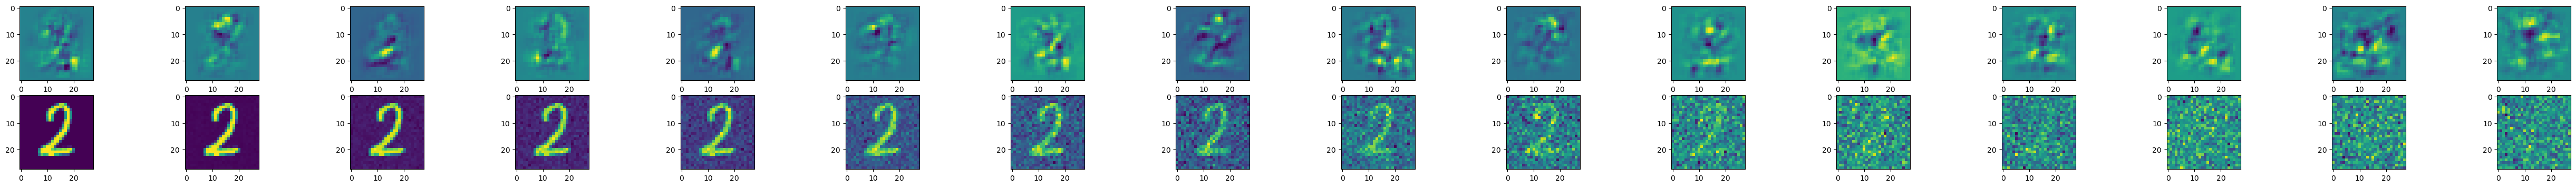

In [6]:
def get_classifier_gradient(x: torch.Tensor, t: torch.Tensor, target: int, scale_factor: float = 8.0):
    classifier.zero_grad()
    x = torch.nn.Parameter(x.to(DEVICE), requires_grad=True)
    t = t.to(DEVICE)
    output = classifier(x,t)
    output[:, target].sum().backward()
    return scale_factor*x.grad.detach()


X_0, Y = trainset[23410]
X_0 = torch.stack([X_0.unsqueeze(0).squeeze()]*n_grid_points)
X_t, noise, score = sde.run_forward(X_0, time_vec)
X_t = X_t.unsqueeze(1)
print(X_t.shape)

fig, axs = plt.subplots(2,16,figsize=(16*4,4))
for idx in range(16):
    gradient = get_classifier_gradient(X_t[idx].unsqueeze(0), torch.tensor([0.05]), Y)
    axs[0,idx].imshow(gradient.detach().cpu().numpy().squeeze())
    axs[1,idx].imshow(X_t[idx].squeeze())

In [7]:
def load_mnist_model():
    model = utils.Unet(base_dim=28, in_channels=1, out_channels=1, time_embedding_dim=256, timesteps=100, dim_mults=[2, 4], temp=100.0)
    model_state_dict = torch.load("mnist_diffusion_denoiser.ckpt")
    model.load_state_dict(model_state_dict)
    model = model.to(DEVICE)
    return model

model = load_mnist_model()


C:\Users\14153\AppData\Local\Temp\ipykernel_26576\1938029714.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("mnist_diffusion_denoiser.ckpt

In [9]:
single_target_shape = [8,1,image_size,image_size]
output_list = []
for target in classes_by_index:
    x_start = torch.clip(torch.randn(size=single_target_shape), -1.0, 1.0)
    print(target, x_start.shape)
    output, time_grid = utils.run_backwards_pics(model, sde, X_0=x_start, n_steps=1000, device=DEVICE, train_score=TRAIN_SCORE, cond_grad_func=get_classifier_gradient, target=int(target), plot_evolution=False)
    output_list.append(output)
output_agg = torch.stack([output.transpose(1,0) for output in output_list],dim=1)
print(output_agg.shape)

0 torch.Size([8, 1, 28, 28])


C:\Users\14153\AppData\Local\Temp\ipykernel_26576\556329269.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


1 torch.Size([8, 1, 28, 28])
2 torch.Size([8, 1, 28, 28])
3 torch.Size([8, 1, 28, 28])
4 torch.Size([8, 1, 28, 28])
5 torch.Size([8, 1, 28, 28])
6 torch.Size([8, 1, 28, 28])
7 torch.Size([8, 1, 28, 28])
8 torch.Size([8, 1, 28, 28])
9 torch.Size([8, 1, 28, 28])
torch.Size([8, 10, 1001, 1, 28, 28])


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
n_time_steps = output_agg.shape[0]
n_labels = output_agg.shape[1]
images_per_label = output_agg.shape[2]
time_idx = -1
#fig, axs = plt.subplots(n_labels, images_per_label)
grid_idx = 0
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(n_labels, images_per_label),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )
for label in range(n_labels):
    for image_idx in range(images_per_label):
        grid[grid_idx].imshow(output_agg[time_idx,label,image_idx].squeeze(),cmap='grey')
        grid[grid_idx].set_xticks([])
        grid[grid_idx].set_yticks([])
        grid[grid_idx].set_ylabel(f"{label}",fontsize=16)
        grid_idx += 1
